# Forecasting Tree Trim Closed Requests

Use time series forecasting to predict the expected number of closed requests in Chicago's 311 system for parkway tree trims requested by city residents between November 2018 - October 2019.

**Project Notebooks Execution Order**
1. [1-data-wrangling-optimize-verify.ipynb](1-data-wrangling-optimize-verify.ipynb)
2. [2-data-wrangling-deduplicate.ipynb](2-data-wrangling-deduplicate.ipynb)
3. [3-exploratory-data-analysis.ipynb](3-exploratory-data-analysis.ipynb)
4. [4-forecasting-opened-requests.ipynb](4-forecasting-opened-requests.ipynb)
5. 5-forecasting-closed-requests.ipynb
6. [6-summary.ipynb](6-summary.ipynb)

For a full explanation of this project, see the `README.md` file at the project root or the `6-summary.ipynb` notebook.

# Import Packages and Modules

In [1]:
from itertools import product
import os
import warnings

from cycler import cycler
from IPython.core.interactiveshell import InteractiveShell
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pandas.plotting as pdplt
import statsmodels.api as sm

# Settings

Configure settings for notebook, plots, files and environmental variables. Set `ast_node_interactivity` to display the output of all expressions in a cell so that more than one data frame can be printed at a time in a single cell. Semicolons at the end of `plt.show();` are used in this notebook to suppress the printing of matplotlib objects in cell outputs. Load functions called in notebook.

In [2]:
# Notebook settings
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
warnings.filterwarnings("ignore")  # matplotlib warnings

# Plot settings
alpha_mpl = 0.75
color_cycle = ['dodgerblue', '#d5019a', 'midnightblue', 'gray']
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle)
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11

# File settings
data_raw = os.path.abspath('./data/raw/')
data_interim = os.path.abspath('./data/interim/')
data_processed = os.path.abspath('./data/processed/')
dir_figures = os.path.abspath('./figures/')

# Import preprocessing and forecasting functions
%run preprocess_data.py
%run forecast.py

# Load Data

In [3]:
df_tt = read_data(
    'Chicago Tree Trims',
    data_processed,
    'chicago-tree-trims.pkl'
)

Chicago Tree Trims
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295577 entries, 118 to 360482
Data columns (total 13 columns):
creation_date_dt           295577 non-null datetime64[ns]
completion_date_dt         287211 non-null datetime64[ns]
status                     295577 non-null category
service_request_number     295577 non-null object
type_of_service_request    295577 non-null category
location_of_trees          181848 non-null category
street_address             295577 non-null object
zip_code                   295577 non-null int64
community_area             295577 non-null int64
latitude                   295485 non-null float64
longitude                  295485 non-null float64
location                   295485 non-null object
is_duplicate               295577 non-null bool
dtypes: bool(1), category(3), datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 83.0 MB
None




Split the data frame into training and test sets. Given the limited number of samples in the dataset, assign twelve months of samples to the test sets. Twelve months is not 20% of the total dataset, which is a reasonable amount for a test set, but it does equal the maximum forecast horizon for this analysis and it contains a full season of data. Also, create training and test sets from the dataset where the Service Request Numbers (SRN) duplicates are removed. The the results of the models with duplicates will be compared to the results of models without duplicates.

In [4]:
df_c_train_has_dupe, df_c_test_has_dupe = split_train_test(
    df_tt,
    'completion_date_dt',
    no_dupe=False,
)
df_c_train_no_dupe, df_c_test_no_dupe = split_train_test(
    df_tt,
    'completion_date_dt',
    no_dupe=True,
)

# Autocorrelation

In a time series context, autocorrelation measures the strength of a linear relationship between lagged values, i.e. an observation and a previous observation at a specific interval.

Plot observations against a single previous time step to visualize the autocorrelation present in the data. Observations at a previous time step are useful for predicting the value at the next time step.

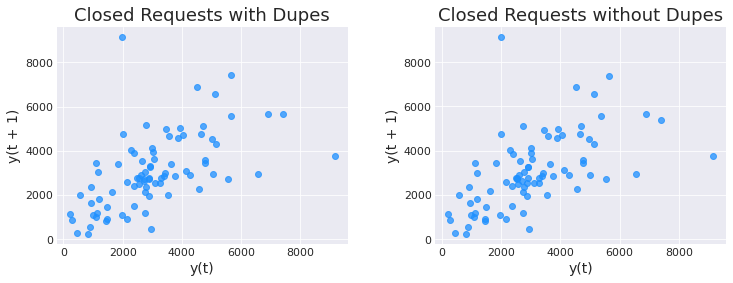

In [5]:
dfs = [
    [df_c_train_has_dupe, 'Closed Requests with Dupes'],
    [df_c_train_no_dupe, 'Closed Requests without Dupes']
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for df, ax in zip(dfs, axes.flat):

    pdplt.lag_plot(df[0]['count'], lag=1, c='C0', alpha=alpha_mpl, ax=ax)
    ax.set_xlabel('y(t)')
    ax.set_ylabel('y(t + 1)')
    ax.set_title(df[1])

plt.show();

The closed requests plots display a positive linear trend. There are only minor differences between the plots with duplicates and without duplicates. 

Review the correlogram plots to determine potential lag values for the model. 

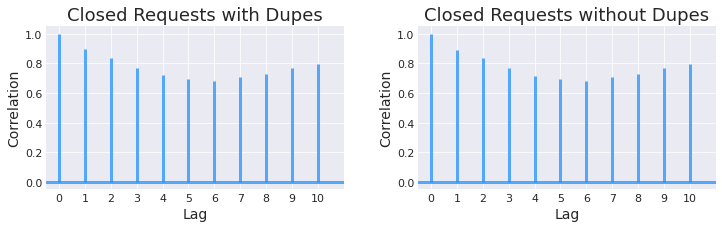

In [6]:
n_lags = 10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
fig.subplots_adjust(hspace=0.6, wspace=0.25)

for df, ax in zip(dfs, axes.flat):

    ax.acorr(
        df[0]['count'].astype(float).tolist(), 
        maxlags=n_lags,
        linewidth=3, 
        color='C0', 
        alpha=alpha_mpl,
    )
    ax.set_xlim(-0.5)
    ax.set_xticks(range(n_lags+1))
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation')
    ax.set_title(df[1])

plt.show();

All of the plots suggest the datasets are correlated. The graphs indicate that a possible value for lag for all datasets is **1.0**.

# Seasonal ARIMA Model

The decomposition results in the `exploratory-data-analysis.ipynb` notebook indicate that the Seasonal Autoregressive Integrated Moving Average (ARIMA) model would be appropriate for forecasting the closed requests. The Seasonal ARIMA model is a time series forecasting method that includes autoregressive terms, differencing operations, moving average terms and a seasonal component. The autoregressive term indicate the number of previous observations used to predict the next value. The differencing term converts a non-stationary time series to stationary, meaning the trend and seasonality of the data does not impact the value of a time series at a specific time. The moving average component uses past forecast errors to predict the next value. The seasonal component backshifts the data by a specified amount, such as 12 for yearly seasonality.

## Parameter Selection

Utilize grid search to find the optimal parameters for the seasonal ARIMA models. The parameters are as follows:

* p = non-seasonal autoregressive term
* d = non-seasonal differencing
* q = non-seasonal moving average term
* P = seasonal autoregressive term
* D = seasonal differencing
* Q = seasonal moving average term
* S = time span of repeating seasonal pattern

In [7]:
p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

**Note:** It takes less than one minute for the closed requests grid searches below to run on a single 3.8 GHz Intel Core i5 processor.

In [8]:
df_gs_c = gs_sarima(df_c_train_has_dupe['count'], pdq, seasonal_pdq)
df_gs_c.head(5)

,pdq,seasonal_pdq,aic
0,"(1, 1, 1)","(0, 1, 1, 12)",982.129096
1,"(0, 1, 1)","(0, 1, 1, 12)",982.867861
2,"(1, 1, 1)","(1, 1, 1, 12)",983.796604
3,"(0, 1, 1)","(1, 1, 1, 12)",984.188762
4,"(1, 0, 1)","(0, 1, 1, 12)",996.711520


In [9]:
df_gs_c_no_dupe = gs_sarima(df_c_train_no_dupe['count'], pdq, seasonal_pdq)
df_gs_c_no_dupe.head(5)

,pdq,seasonal_pdq,aic
0,"(1, 1, 1)","(1, 1, 1, 12)",979.685666
1,"(1, 1, 1)","(0, 1, 1, 12)",981.989123
2,"(0, 1, 1)","(0, 1, 1, 12)",982.902847
3,"(0, 1, 1)","(1, 1, 1, 12)",984.122309
4,"(1, 0, 1)","(0, 1, 1, 12)",996.609991


The parameters are slightly different between the data with duplicate and the data without duplicates, and the AIC without duplicates is lower. Going forward, use the datasets without duplicates. 

## Fit the Model

Fit the seasonal ARIMA model for closed requests without duplicates.

In [10]:
param = df_gs_c_no_dupe.loc[0, 'pdq']
s_param = df_gs_c_no_dupe.loc[0, 'seasonal_pdq']
sarima = sm.tsa.statespace.SARIMAX(
    df_c_train_no_dupe['count'],
    order=param,
    seasonal_order=s_param,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_c = sarima.fit()
print(sarima_c.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              count   No. Observations:                   82
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -484.843
Date:                            Tue, 05 May 2020   AIC                            979.686
Time:                                    23:32:13   BIC                            989.722
Sample:                                01-01-2011   HQIC                           983.567
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4254      0.147      2.900      0.004       0.138       0.713
ma.L1         -0.9676      0.201   

Not all of the coefficients are significant in this model. However, the AIC for this model is the lowest of all of the models that were fit using grid search, so keep all of the coefficients in the model.

Also, the Ljung-Box p-value is not significant, indicating we should fail to reject the null hypothesis. Therefore, the residuals are independently distributed.

**Plot Diagnostics**

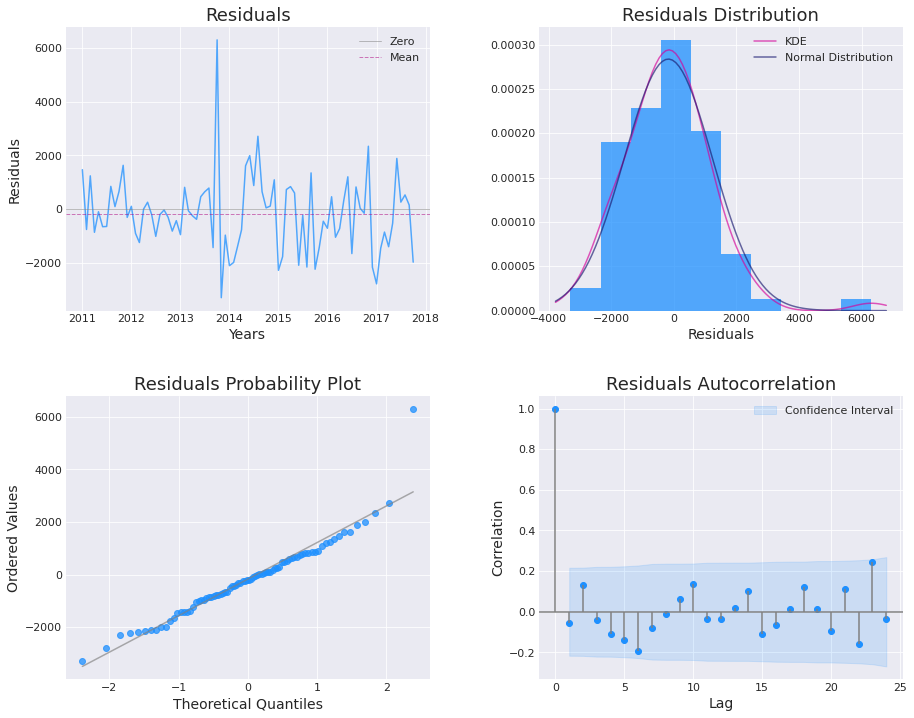

In [11]:
sarima_c_fig = sarima_diagnostics(sarima_c.resid, alpha_mpl)
plt.show();

The model residuals are random without correlation and there is no obvious seasonal or trend information in the residual plot. In the histogram plot, the Kernel Density Estimate is very close to normal, even with a slight skew to the right. The probability plot is very close to normal, and the Autocorrelation plot indicates the residuals are not correlated.

## Forecast

Using the Seasonal ARIMA models fitted above, forecast the volume of closed requests for the next twelve months and then compare those results with the test set. How well do the models fit the test data? 

Compare the predicted values against observed values in the training set.

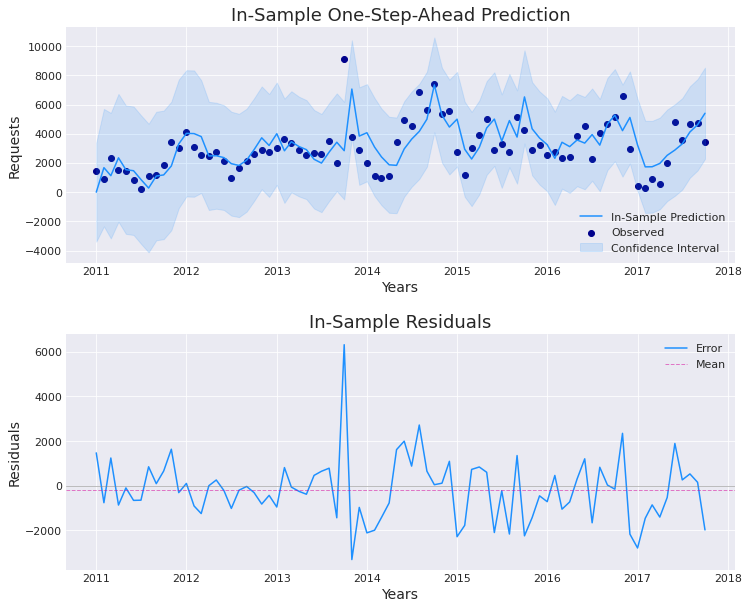

In [12]:
fcast_c_in, ci_c_in, resid_c_in = forecast_in_sample(sarima_c)

fig_c_in_sample = plot_in_sample_forecast(
    fcast_c_in, 
    ci_c_in, 
    resid_c_in,
    df_c_train_no_dupe,
)
plt.show();

The confidence intervals for the closed requests are very wide on the left side of the plot narrow slightly as the plot moves to the right. They remain fairly wide as compared to the opened requests confidence intervals. 
The October 2013 outlier sits above the confidence interval. The residuals are random. There is a dramatic peak in 2013, which corresponds to the October 2013 spike in closed requests.

### Model Performance

To evaluate the performance of the model, calculate both the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE).  The RMSE is commonly used to evaluate performance on a time series model, however it is more sensitive to occasional large forecast errors, such as the October 2013 error. This is because squaring the error in RMSE heavily weights large errors. Both RMSE and MAE return results in the original units of the dataset.

In [13]:
mae_c_in, rmse_c_in, mape_c_in = eval_metrics(
    fcast_c_in, 
    df_c_train_no_dupe['count']
)

pd.DataFrame(
    [
        ['MAE', mae_c_in], 
        ['RMSE', rmse_c_in], 
        ['MAPE', mape_c_in]
    ],
    columns=['Metric', 'Value'])

,Metric,Value
0,MAE,1050.879877
1,RMSE,1417.051438
2,MAPE,58.526559


There is no standard criteria for evaluating the MAE and RMSE results as they depend on the range of values in the dataset used to fit the model. However, lower scores are better when comparing these evaluation metrics between different models based on the same dataset. Plot the MAE and RMSE results against the range of values for closed requests. 

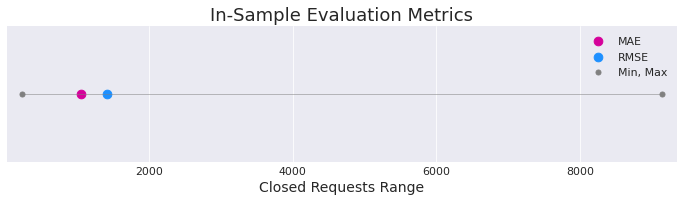

In [14]:
fig_c_in_metrics = plot_eval_metrics(
    df_c_train_no_dupe, 
    mae_c_in, 
    rmse_c_in,
    'Closed', 
    'In',
)
plt.show();

Both MAE and RMSE are very low on the range of values in the closed requests data. As expected, the MAE value is lower than the RMSE value.

**Test Set Out-of-Sample Forecast**

How well do the model predictions fit the test set? Limit the plot from 2014 onwards to zoom into the forecast results

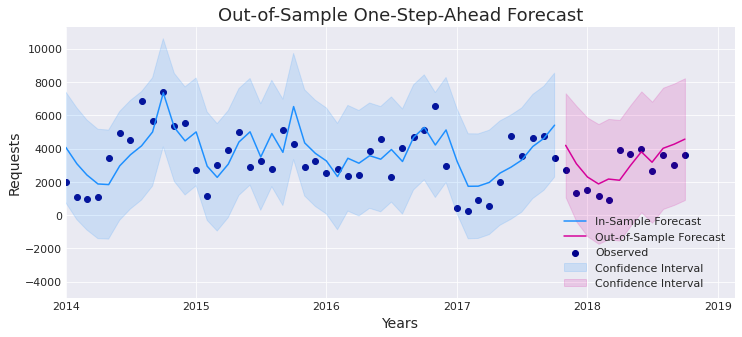

In [15]:
fcast_c_out, se_c_out, ci_c_out = forecast_out_sample(sarima_c, False)

fcast_c = (fcast_c_in, fcast_c_out, ci_c_in, ci_c_out)

fig_c_out_sample = plot_out_sample_forecast(
    df_c_train_no_dupe,
    df_c_test_no_dupe,
    False,
    fcast_c,
)
save_fig('fig_c_out_sample', dir_figures)
plt.show();

The predicted values of the test set are relatively close to the observed values, given the volatility of the dataset. What are the MAE and RMSE of the predictions on the test set?

In [16]:
mae_c_out, rmse_c_out, mape_c_out = eval_metrics(fcast_c_out, 
                                                 df_c_test_no_dupe['count'])

pd.DataFrame(
    [
        ['MAE', mae_c_out], 
        ['RMSE', rmse_c_out], 
        ['MAPE', mape_c_in]],
    columns=['Metric', 'Value']
)

,Metric,Value
0,MAE,983.524994
1,RMSE,1106.266276
2,MAPE,58.526559


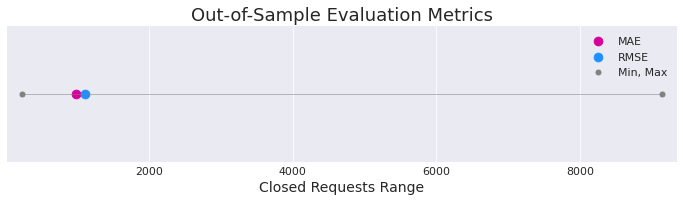

In [17]:
fig_c_out_metrics = plot_eval_metrics(
    df_c_train_no_dupe, 
    mae_c_out,
    rmse_c_out, 
    'Closed', 
    'Out-of',
)
save_fig('fig_c_out_metrics', dir_figures)
plt.show();

The MAE and RMSE scores have improved, so the model is not overfitting the data. 

**Test Set Forecast Errors**

In which months did the forecast produce the most extreme errors?

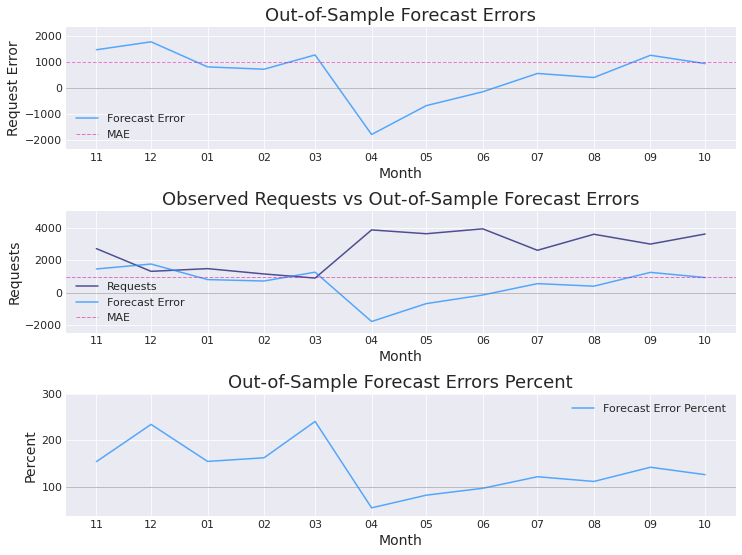

In [18]:
fig_c_err = plot_forecast_errors(
    fcast_c_out, 
    ci_c_out,
    df_c_test_no_dupe['count'],
    alpha_mpl, 
    mae_c_out,
)
plt.show();

The forecast over predicted the number of requests in November and December by a wide margin and under predicted the number of requests In April, May and June also by a wide margin. The percent plot indicates that the forecast is generally over estimating the request volume, especially in November - March.

**Test Set Forecast Confidence Intervals**

The confidence intervals for the out-of-sample forecast should generally widen as the forecast horizon increases, indicating an increase in uncertainty. Plot the confidence intervals over time to verify this assumption.  

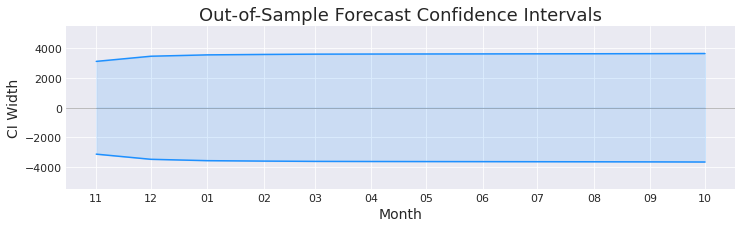

In [19]:
fig_c_ci = plot_forecast_ci(ci_c_out)
plt.show();

As expected, the forecast confidence intervals gradually widen as the forecast horizon increases.

### Twenty Four Month Forecast

What is the expected volume of closed requests from November 2018 - October 2019?

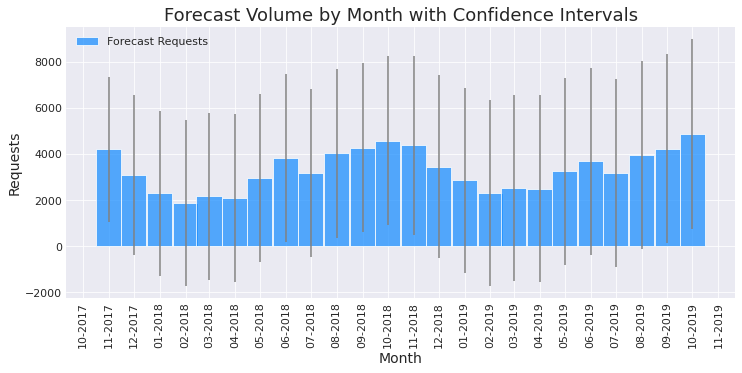

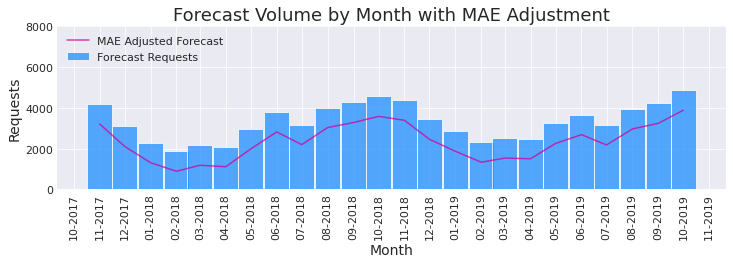

In [20]:
fig_c_vol_no_err, fig_c_vol_has_err = plot_forecast_volume(
    sarima_c,
    df_c_test_no_dupe,
    alpha_mpl,
    mae_c_out,
)
plt.show();

The closed requests data is more volatile than the opened requests data and that is reflected in fit of the model. The confidence intervals are wider than the opened requests confidence intervals, and the MAE score of the closed requests test set is nearly triple the MAE score of the opened requests test set. 

# Conclusions

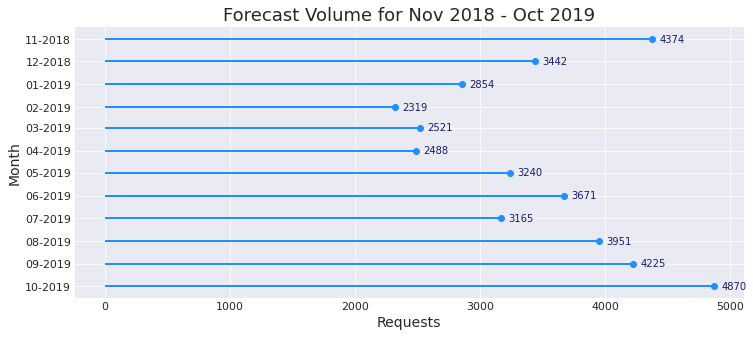

In [21]:
fig_c_fcast_values = plot_forecast_values(sarima_c, alpha_mpl)
fig_file = os.path.join(dir_figures, 'fig_c_fcast_values.png')
plt.savefig(fig_file, format='png')
plt.show();

The forecast predicts a low of **2305** closed requests in February 2019 and a high of **4844** requests in October 2019.

Ideas for improving the model for closed requests are listed in the Next Steps section of the `summary.ipynb` notebook.